# Zindi: Financial Inclusion in Africa
## Task at hand: Predict who is most likely to have a bank account.

Financial Inclusion remains one of the main obstacles to economic and human development in Africa. For example, across Kenya, Rwanda, Tanzania, and Uganda only 9.1 million adults (or 13.9% of the adult population) have access to or use a commercial bank account.

Traditionally, access to bank accounts has been regarded as an indicator of financial inclusion. Despite the proliferation of mobile money in Africa, and the growth of innovative fintech solutions, banks still play a pivotal role in facilitating access to financial services. Access to bank accounts enable households to save and facilitate payments while also helping businesses build up their credit-worthiness and improve their access to other finance services. Therefore, access to bank accounts is an essential contributor to long-term economic growth.

The objective of this project is to create a machine learning model to predict which individuals are most likely to have or use a bank account. The models and solutions developed can provide an indication of the state of financial inclusion in Kenya, Rwanda, Tanzania and Uganda, while providing insights into some of the key demographic factors that might drive individuals’ financial outcomes.

The main dataset contains demographic information and what financial services are used by approximately 33,610 individuals across East Africa. This data was extracted from various Finscope surveys ranging from 2016 to 2018. Your goal is to accurately predict the likelihood that an individual has a bank account or not, i.e. Yes = 1, No = 0.

In [25]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib 
import matplotlib.pyplot as plt 
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

sns.set()

%matplotlib inline

# Load the dataset

In [26]:
data = pd.read_csv('train.csv')
data.head()

,country,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


## Variable definitions are supplied. Lets load them in and have a look.

In [27]:
definitions = pd.read_csv('VariableDefinitions.csv')
display(HTML(definitions.to_html()))

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,uniqueid,Unique identifier for each interviewee
2,location_type,"Type of location: Rural, Urban"
3,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
4,household_size,Number of people living in one house
5,age_of_respondent,The age of the interviewee
6,gender_of_respondent,"Gender of interviewee: Male, Female"
7,relationship_with_head,"The interviewee’s relationship with the head of the house:Head of Household, Spouse, Child, Parent, Other relative, Other non-relatives, Dont know"
8,marital_status,"The martial status of the interviewee: Married/Living together, Divorced/Seperated, Widowed, Single/Never Married, Don’t know"
9,education_level,"Highest level of education: No formal education, Primary education, Secondary education, Vocational/Specialised training, Tertiary education, Other/Dont know/RTA"


## Check dtypes

In [4]:
data.dtypes

country                   object
uniqueid                  object
bank_account              object
location_type             object
cellphone_access          object
household_size             int64
age_of_respondent          int64
gender_of_respondent      object
relationship_with_head    object
marital_status            object
education_level           object
job_type                  object
dtype: object

## Use pandas.describe() to showcase continuous features

By inspecting the data types, you can see that there are more categorical features than numeric features. Perform the statistical summary of the numeric features

In [5]:
#Insert code here
data.describe()

,household_size,age_of_respondent
count,23524.000000,23524.000000
mean,3.797483,38.805220
std,2.227613,16.520569
min,1.000000,16.000000
25%,2.000000,26.000000
50%,3.000000,35.000000
75%,5.000000,49.000000
max,21.000000,100.000000


## Drop irrelevant features

Before performing full exploratory data analysis, check the dataset to see a feature that will not be needed in analysis. If you see one, drop the feature

In [28]:
#Insert Code here
data.drop('uniqueid', axis=1, inplace=True)

## Check for any missing values

There is no data that is absolutely clean. Data may have missing have values due to miscalculation error, bad recording instruments, expert negligence, and oversight. Checking and filling in missing values or deleting the entire features are necessary.

In [7]:
#Insert Code here
data.isna().sum()

country                   0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

# Exploratory Data Analysis
## Analysing input features:

There are two numeric features: household_size, age_of_respondent

The remaining are all categorical.


## Univariate Analysis

In univariate data analysis, the statistical analysis of a single variable is performed. Here you are to analyse and report the distribution of the two numeric features individually using density histogram (displot), absolute frequencies (displot) and boxplots. 

[Text(0.5, 1.0, 'Distribution of household size')]

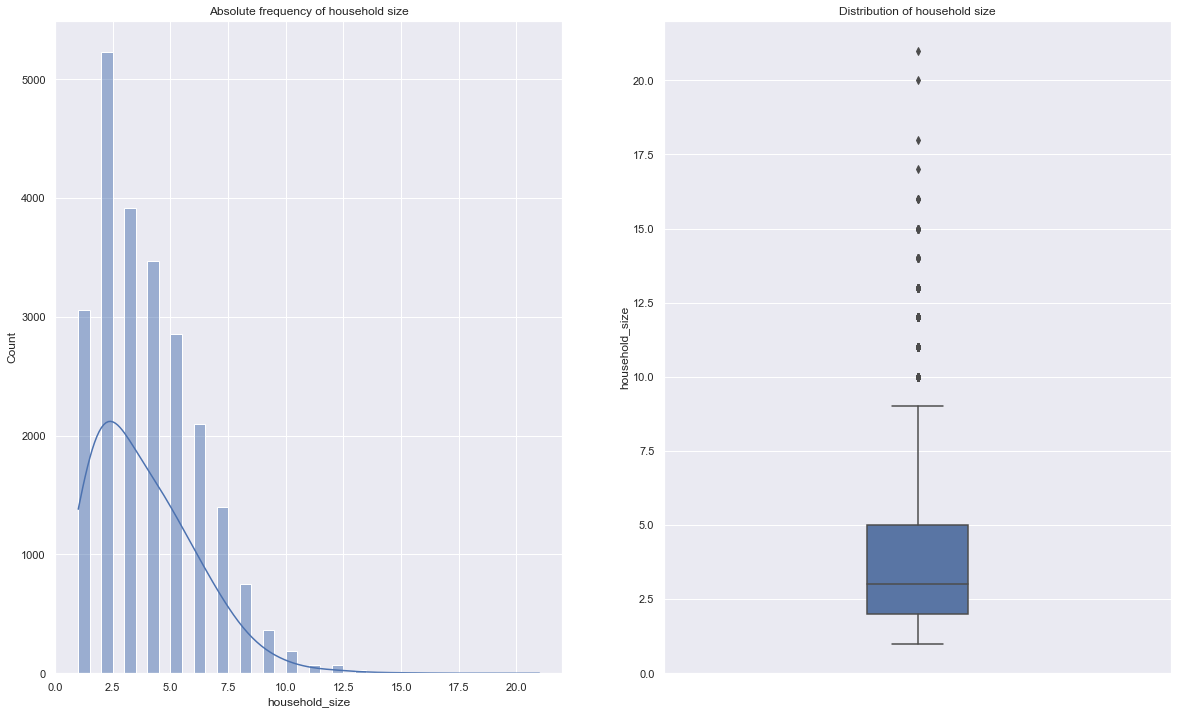

In [8]:
#Insert Code here
fig, ax = plt.subplots(1,2,figsize=(20,12))
sns.histplot(data, x='household_size', kde = True, kde_kws={"bw_adjust":3}, ax=ax[0], 
             binwidth=0.5).set(title='Absolute frequency of household size')
sns.boxplot(data=data, y='household_size', ax=ax[1], 
            width=0.2).set(title='Distribution of household size')

[Text(0.5, 1.0, 'Distribution of the age of respondent')]

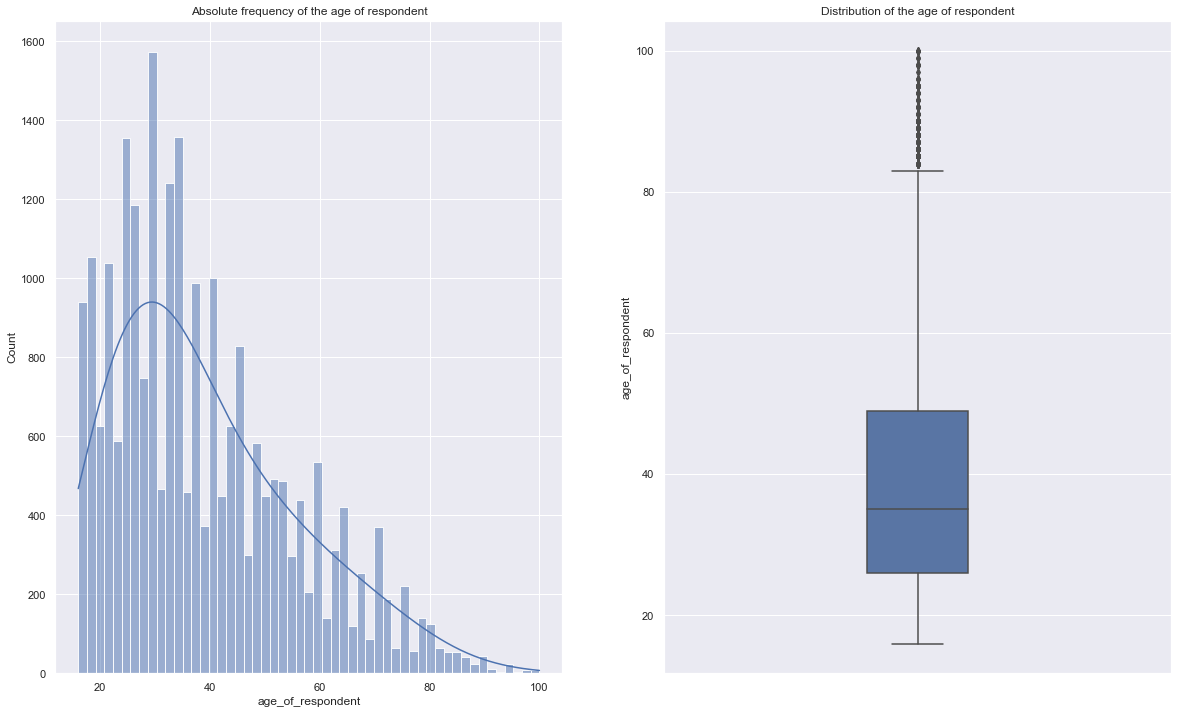

In [9]:
fig, ax = plt.subplots(1,2,figsize=(20,12))
sns.histplot(data, x='age_of_respondent', kde=True, kde_kws={"bw_adjust":3}, 
             ax=ax[0]).set(title='Absolute frequency of the age of respondent')
sns.boxplot(data=data, y='age_of_respondent', ax=ax[1], 
            width=0.2).set(title='Distribution of the age of respondent')

## Check Outliers in each numeric features.

Yes, outliers can be tricky. They often confuse the model to capture the underlying relationship of the data distribution. You may use one of z-score or interquartile range (IQR) methods to check for outliers in each numeric feature

## NOTE: 

Check if you have a fairly large amount of outliers on both these features. If you do, what decision will you prefer to take at this point? Provide a report on why you take your decision to deal with outliers.

However, remember that machine learning algorithms produce better performance on data with considerable large amoung of amount of training instances.



In [29]:
#Insert Code here
def find_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    IQR = Q3 - Q1

    outliers = (df<(Q1-1.5*IQR))|(df>(Q3+1.5*IQR))
    return outliers.value_counts()

outliers_house = find_outliers(data.household_size)
outliers_age = find_outliers(data.age_of_respondent)
print(outliers_house)
print(outliers_age)

False    23143
True       381
Name: household_size, dtype: int64
False    23283
True       241
Name: age_of_respondent, dtype: int64


The outliers will not be removed due to the large number of outliers in both of these features.
These outlier values are a part of the normal population distribution and removing them could reduce model performance.

## Bivariate analysis

You can recall that the providing insights into some of the key demographic factors that might drive individuals’ financial outcomes is compulsory as stated in the problem. Then there is need to perform bivariate analysis between the two numeric features (independent variables) and the target or dependent variable (bank account).

Again, use density histogram, absolute frequencies and boxplot to perform the bivariate analysis between:

(a) the first numeric feature and the target
(b) the second numeric feature and the target

<AxesSubplot:xlabel='bank_account', ylabel='household_size'>

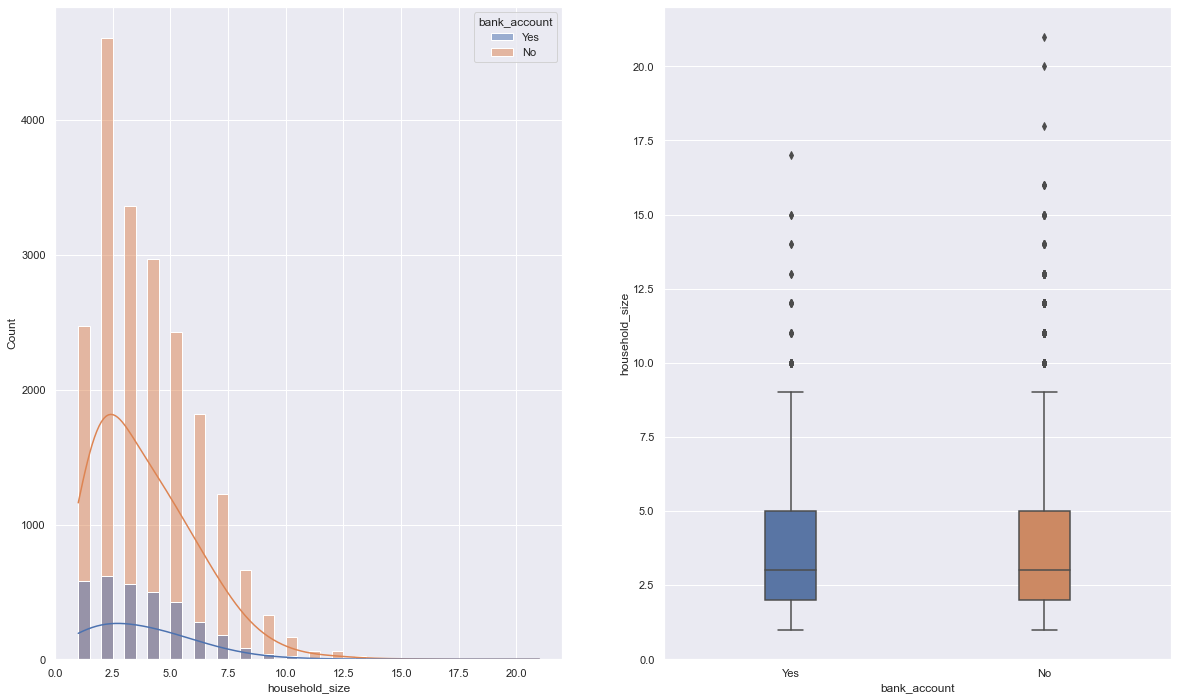

In [11]:
fig, ax = plt.subplots(1,2,figsize=(20,12))

sns.histplot(data, x='household_size', hue='bank_account',
             kde = True, kde_kws={"bw_adjust":3}, ax=ax[0], binwidth=0.5)

sns.boxplot(data=data, x='bank_account', y='household_size', 
            ax=ax[1], width=0.2)

<AxesSubplot:xlabel='bank_account', ylabel='age_of_respondent'>

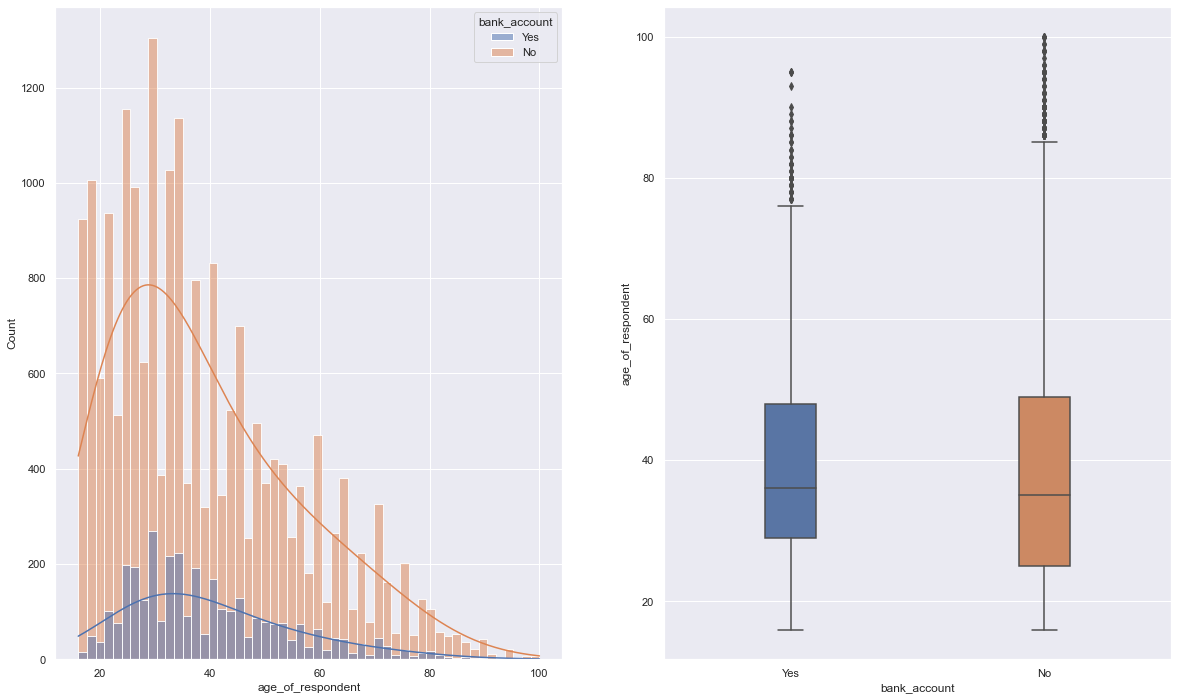

In [12]:
fig, ax = plt.subplots(1,2,figsize=(20,12))

sns.histplot(data, x='age_of_respondent', hue='bank_account', 
             kde = True, kde_kws={"bw_adjust":3}, ax=ax[0])

sns.boxplot(data=data, x='bank_account', y='age_of_respondent', 
            ax=ax[1], width=0.2)

The most prominent pattern here is the high imblance in target classes. This is clearly visible in the histograms.

It also seems that there is no large difference in the distribution of household_size, depending on whether the person has a bank account or not.

For the individual's age however, there is a slight tendency for older aged individuals to have a bank account.

## Multi-variate analysis

Now that we have seen how individual numeric feature relate to the target, it is necessary to see how the two numeric features simultaneously relate to the target. A multi-variate analysis on this relationship using boxplot has been performed. Report your observation of the age group (18-50-> youth,  50 and above-> Old) that is more likely to have a bank account. Also report same for house_size for individuals staying alone and two or more people living together.

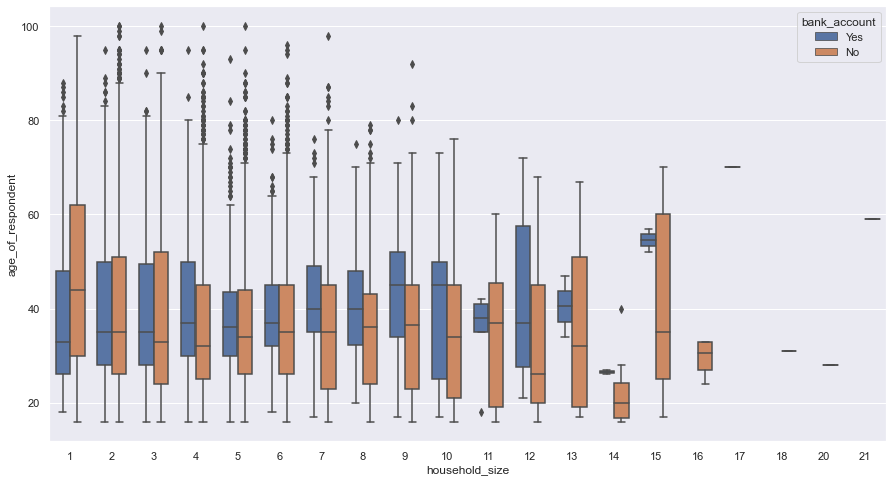

In [13]:
# boxplot
plt.figure(figsize=(15,8))

sns.boxplot(data=data, y='age_of_respondent',x='household_size',hue='bank_account',width=0.7)

plt.show()

When living alone it is more likely that youth will have a bank account compared to when 2 or more people live together. However, when two or more people live together the tendency for older individuals to have a bank account is seen.

## Categorical (Nominal) Features
We seek to visualize the data distributions for the following features:

country, 
location_type, 
cellphone_access,
gender_of_respondent,
relationship_with_head, 
marital_status,
education_level,
job_type

These categorical attributes are analyzed using barplots.

## Bivariate analysis

We are to perform a bivariate analysis of each nominal feature with the target variable (bank account). The relationship between country and bank account has been performed. Do same for other idenfied nominal variables.

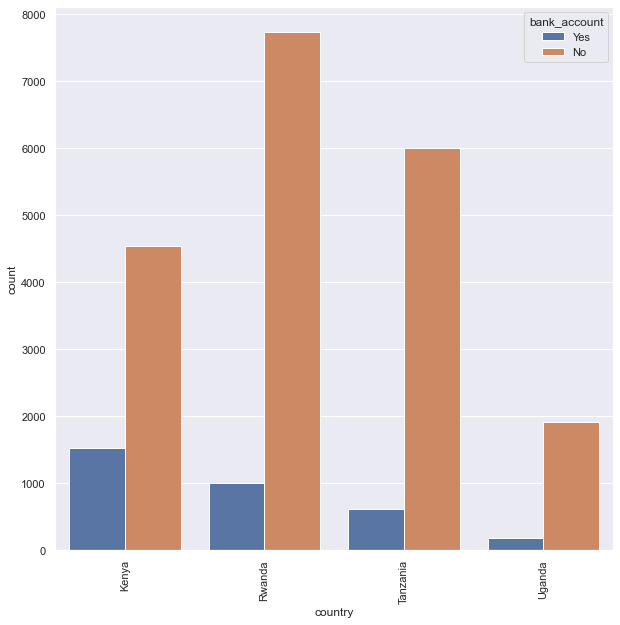

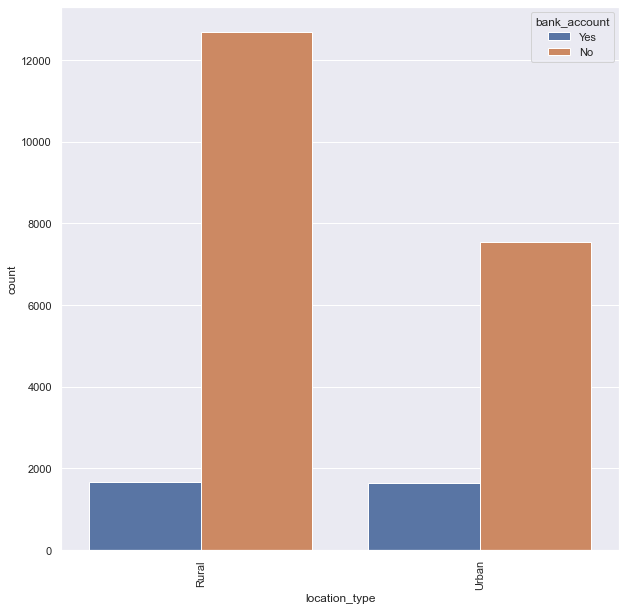

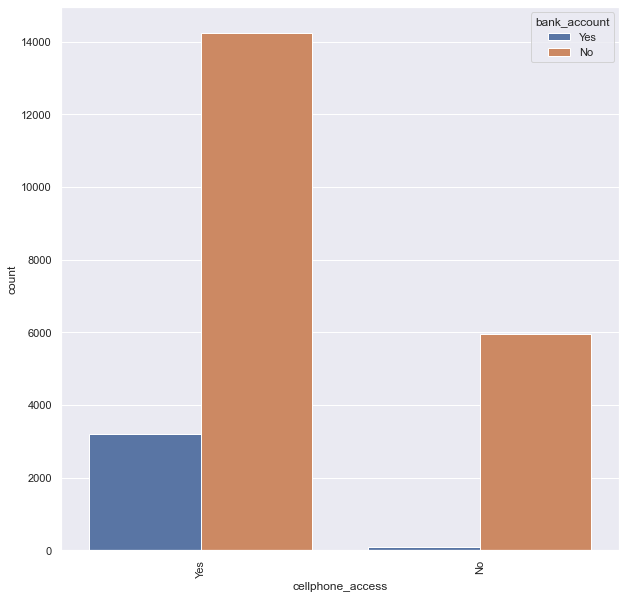

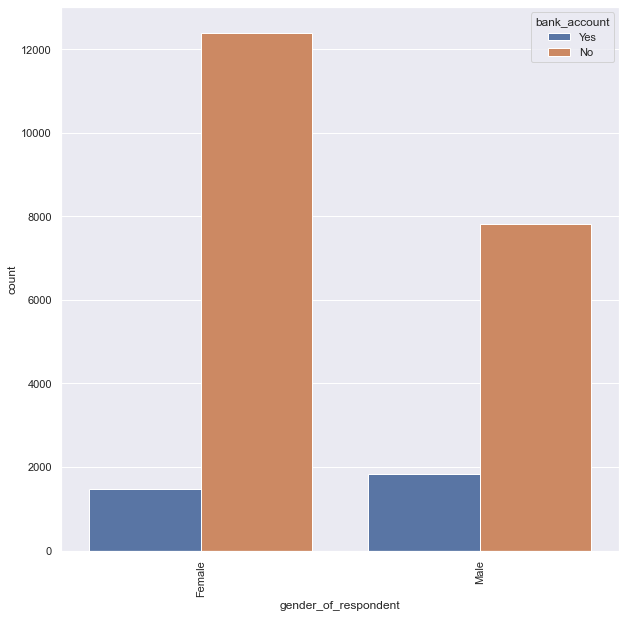

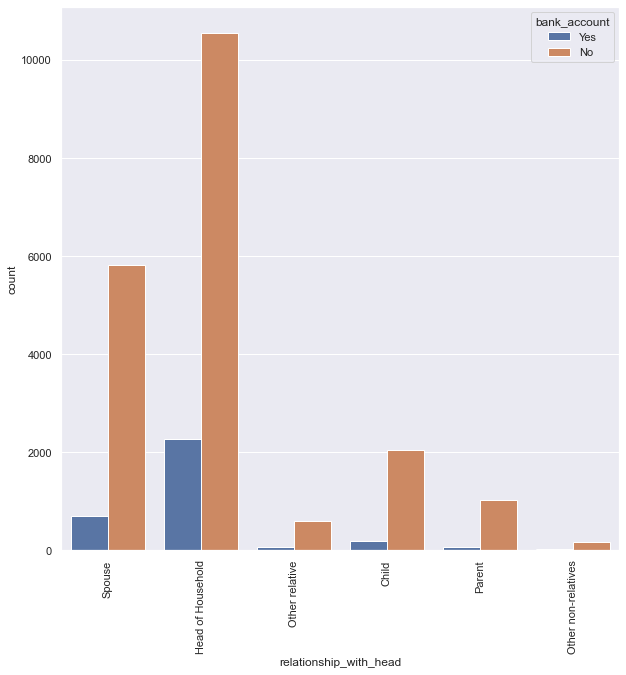

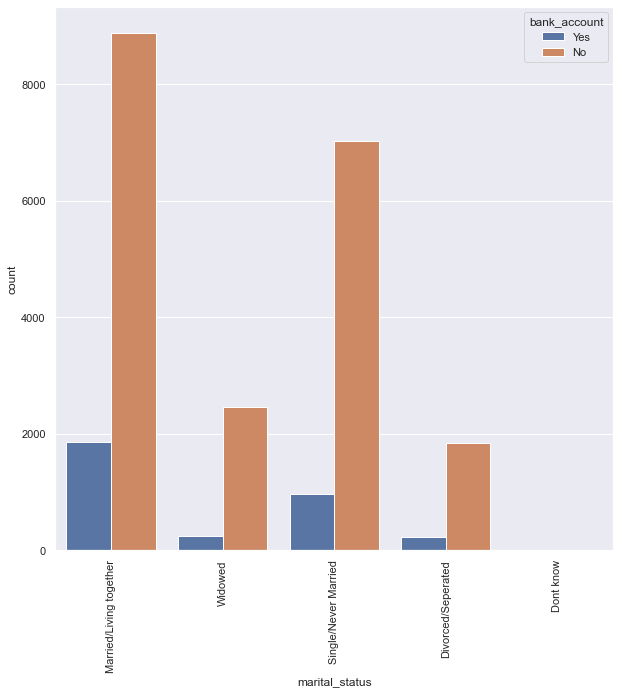

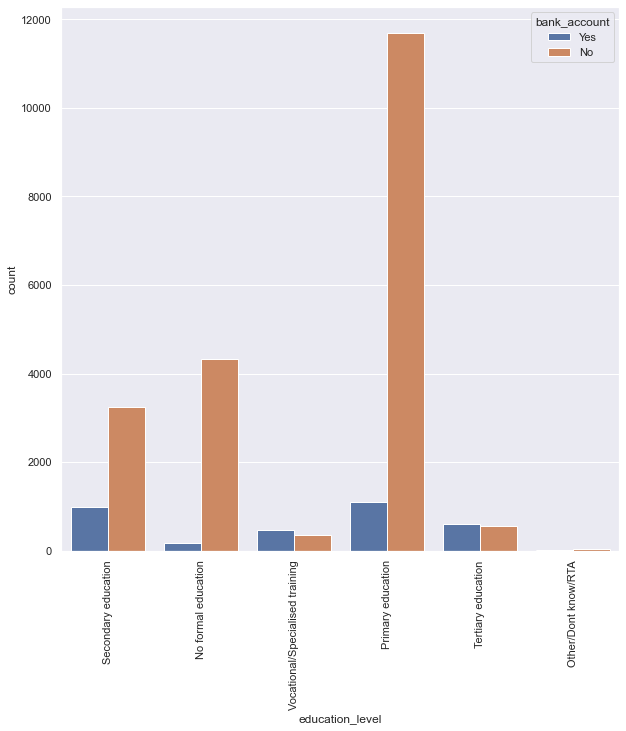

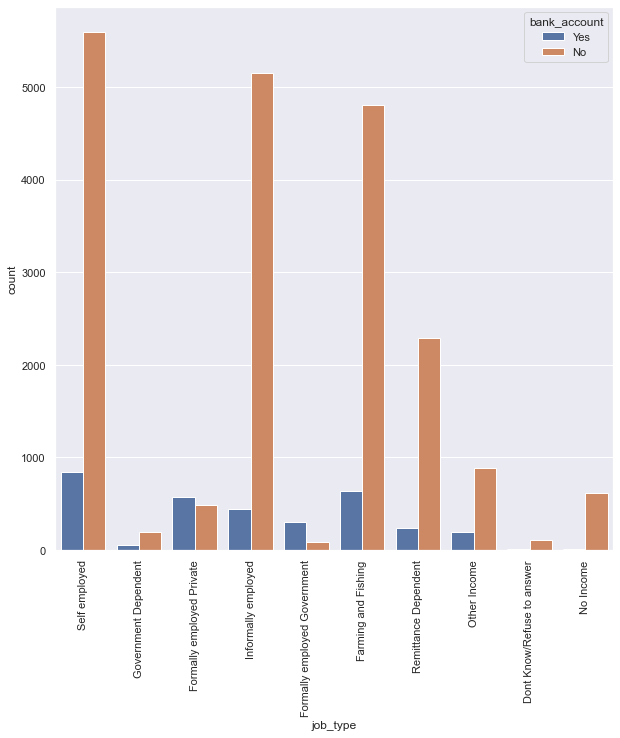

In [14]:
categories = ['country', 'location_type', 'cellphone_access', 
              'gender_of_respondent', 'relationship_with_head', 
              'marital_status', 'education_level', 'job_type']
for i, cat in enumerate(categories):
    plt.figure(figsize=(10,10))
    sns.countplot(x =cat, data=data, hue='bank_account')
    plt.xticks(rotation=90)

## Univariate analysis of the target feature

To obtain a model with good generalization, it's a great idea to check the class distribution of the target attribute. From the observation, you can see that the class distribution is skewed. What necessary action would you take from here? Show your code after the graph.

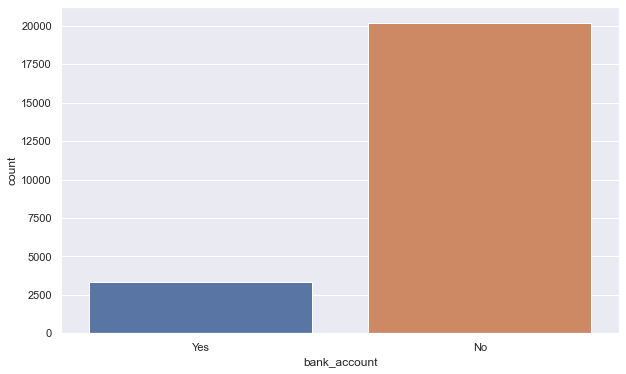

In [15]:
f, ax = plt.subplots(1,1,figsize=(10,6))
sns.countplot(x ='bank_account', data=data, ax=ax)
plt.show()

Notice the number of observations in the dataset with bank_account = 'Yes' is much less than 'No'

In [16]:
#Insert Code here
smote = SMOTE()
data_smote = smote.fit_resample(data)

print(Counter(data))
print(Counter(data_smote))

TypeError: fit_resample() missing 1 required positional argument: 'y'

## Exploratory data analysis conclusion

Here, provide your observation about the exploratory data analysis process. Your conclusion should give an insight into the type of machine learning suitable for this problem. Do all the variables show correlation to the target attribute? How do you intend to deal with the problem of outliers and imbalance classes. In case you select a ML algorithm, what criteria did you consider for your selection?




# Enoding the data

In most of our lectures, we discussed that machine learning algorithms perform better on numeric features. Next we need to convert the strings in our dataset into integers/floats otherwise our model would be unable to interpret them.

The values of target variable (bank account), 'Yes' and 'No', have been replaced with 1 and 0. You are to perform one-hot encoding for the nominal variables to avoid imposing any sort of linear relationship onto these nominal attributes

In [30]:
data['bank_account'] = data['bank_account'].apply(lambda x: 0 if x == 'No' else 1)
data.head()

,country,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,1,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,0,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,1,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,0,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,0,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [31]:
#Insert Code here
df = pd.get_dummies(data, drop_first =True)
df.head()

,bank_account,household_size,age_of_respondent,country_Rwanda,country_Tanzania,country_Uganda,location_type_Urban,cellphone_access_Yes,gender_of_respondent_Male,relationship_with_head_Head of Household,...,education_level_Vocational/Specialised training,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,1,3,24,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,5,70,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,1,5,26,0,0,0,1,1,1,0,...,1,0,0,0,0,0,0,0,0,1
3,0,5,34,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,8,26,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0


## Splitting Data

Next, separate input data from class labels. Then split the dataset into a training set, validation set and test set using 80:10:10 respectively

In [32]:
#Insert Code here
y = df.bank_account.values
df.drop('bank_account', axis=1, inplace=True)

In [33]:
X_train, X_remain, y_train, y_remain = train_test_split(df, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=42)

## Scaling data

Next scale the input data, so that all features have a mean of 0 and a standard deviation of 1.

Differences in the scales across input variables may increase the difficulty of the problem being modeled. An example of this is that large input values (e.g. a spread of hundreds or thousands of units) can result in a model that learns large weight values. A model with large weight values is often unstable, meaning that it may suffer from poor performance during learning and sensitivity to input values resulting in higher generalization error.

In [34]:
#Insert Code here
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

# Example: Selection of Random Forest Classifier.

Random forest classifier has been used as an example of the next processes you will be performing. However, you are going to select another ML algorithm and follow the processes below. Identify the hyparameters of the ML algorithm you have selected, then train and validate several models using different hyparameter value. Select the best model. 

## Training the model
Here, random forest algorithm was selected and the parameters optimised. This is done by optimising by training several models with differing hyperparameter values and comparing their performance on the validation set.

There are a number of hyperparameter involved in Random Forest Classifiers. Those applicable here are:
 - Minimum samples per leaf node
 - Ensemble size
 - Maximum tree depth

Leaving the depth of a tree unrestrained will result in trees with large variance. This is not a problem because by decorrelating our trees (this is where the random, in random forest comes to play) and ensembling them thereafter, we can drive the final variance of our model significantly down. Therefore, this hyperparameter is assigned the default value of 'None'.

The larger the ensemble size, the lower that variance error will be driven. However, there are diminishing returns and an increase in computational cost associated with increasing this hyperparameter. We leave this value as the default value of 100.

The final hyperparmater that we will be tuning for is the minimum samples per leaf node. 
Leaving this value to be the default of 1 could benefit our model's capability to naturally handle outliers.
Note that doing so could cause our model to overfit on the dataset. Assigning a value of 10, for example, would result in the average over a minimum of 10 observations being used to determine the output of a leave node. Beyond a certain value, this will prevent Random Forest from handling the class imbalance properly. 

We will tune this hyperparameter by training models with the following values:
\[1, 2, 3, 5, 10, 15\]

The best performing value will be chosen for the final model.

 
  

In [35]:
models = []
parameters = [1,2,3,5,10,15]

i=0
for value in parameters:
    models.append(RandomForestClassifier(n_jobs=-1, min_samples_leaf=value))
    models[i].fit(X_train,y_train)
    i+=1

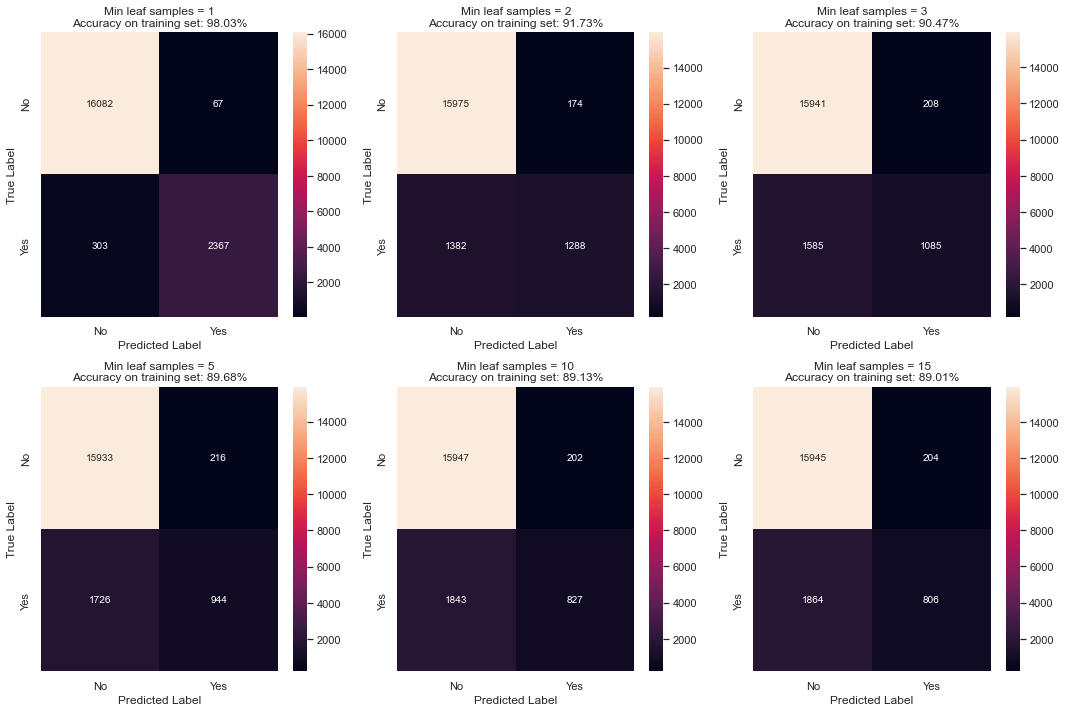

In [36]:
fig, ax = plt.subplots(2,3,figsize=(15,10))
ax = ax.flatten()
train_score = []

i=0
for axes in ax:
    # predict values
    trainPredicted = models[i].predict(X_train)
    y = ['No', 'Yes']

    # print confusion matrix
    sns.heatmap(confusion_matrix(y_train,trainPredicted),annot=True,fmt='d',yticklabels=y,xticklabels=y, ax=axes)
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')
    
    # compute score
    score = accuracy_score(y_train,trainPredicted)*100
    train_score.append(score)
    axes.set_title("Min leaf samples = {}\nAccuracy on training set: {:.2f}%".format(parameters[i],score))
    i+=1


plt.tight_layout()
plt.show()
#print()

Things to notice here:
 - For minimum leaf samples set to 1 there are very little false negatives, showing that random forest can account for class imbalance. However, this could be accompanied by overfitting.
 - The number of True negatives is consistent throughout.
 - The model's variance is decreased with increase in minimum leaf samples. This is clear through the decline in flase negatives.

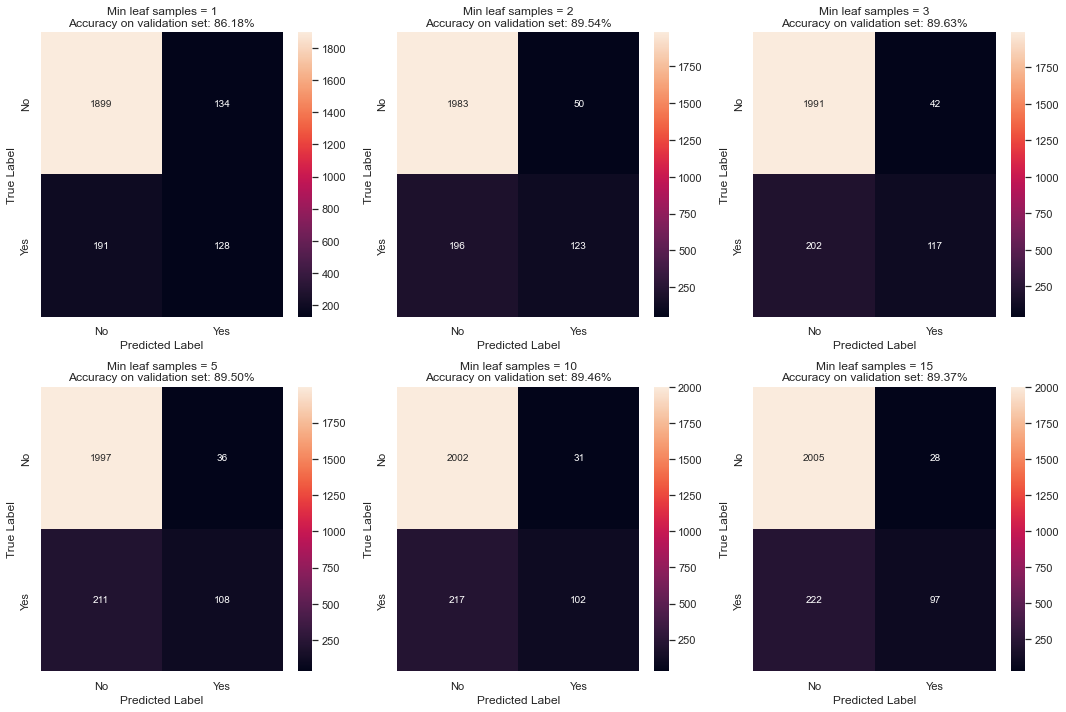

In [38]:
fig, ax = plt.subplots(2,3,figsize=(15,10))
ax = ax.flatten()
valid_score = []

i=0
for axes in ax:
    # predict values 
    validPredicted = models[i].predict(X_val)
    
    # print confusion matrix
    y = ['No', 'Yes']
    sns.heatmap(confusion_matrix(y_val,validPredicted),annot=True,fmt='d',yticklabels=y,xticklabels=y, ax=axes)
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')

    # compute score
    score = accuracy_score(y_val,validPredicted)*100
    valid_score.append(score)
    axes.set_title("Min leaf samples = {}\nAccuracy on validation set: {:.2f}%".format(parameters[i],score))
    i+=1


plt.tight_layout()
plt.show()
#print()

## Interpretation of Accuracy and confusion matrix 

Looking at the results on the validation set confirms that the model did indeed overfit for minimum leaf samples set to 1. Shown by the high amount of false positives and low accuracy. However, this did result in the lowest overall number of false negatives. 

The model initially showed good performance on the training set, regardless of the high class imbalance. However, on the validation set its performance degraded significantly. Considering how large the imbalance was Random Forest performed quite well without any resampling of the dataset.

The biggest problem is that we are classifying someone who actually has a bank account wrongly, more often than not. The number of false negatives are greater than true positives.

## To illustrate the point of overfitting.

In [39]:
results = {'Min_leaf_samples':parameters, 'Train Score':train_score, 'Valid Score':valid_score}

result_df = pd.DataFrame(results)
display(HTML(result_df.to_html()))

,Min_leaf_samples,Train Score,Valid Score
0,1,98.033902,86.181973
1,2,91.731760,89.540816
2,3,90.472395,89.625850
3,5,89.680642,89.498299
4,10,89.133323,89.455782
5,15,89.011106,89.370748


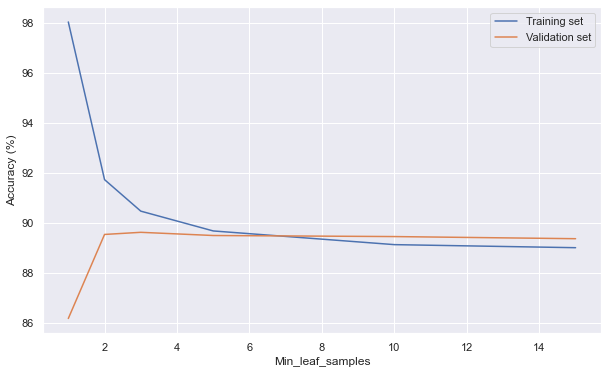

In [40]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
sns.lineplot(data=result_df, x='Min_leaf_samples', y='Train Score', ax = ax, label='Training set')
sns.lineplot(data=result_df, x='Min_leaf_samples', y='Valid Score', ax = ax, label= 'Validation set')
ax.set_ylabel('Accuracy (%)')
plt.show()

The ideal value for the hyperparameter seems to be 5. However, we alreay know that there are more false negatives than false positives for both the training set and the validation set for this value. As well as a much larger number of false negatives as apposed to true positives. 

The model is great at predicting if people don't have a bank account. Unfortunately the same cannot be said for the inverse.

Leaving the model in this state would be fallacious as the highly imbalanced classes still results in the model producing too many false negatives, regardless of its accuracy score.

# Therefore we opt to tackle the class imbalance artificially.

Our goal here is to minimise the ratio of the predictor variable. To do so, the minority class must be increased in size, and the majority class decreased.

There are several different techniques to achieve this, here we decide to use SMOTE combined with random under sampling.

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. This approach is effective because new synthetic examples from the minority class are created that are plausible, that is, are relatively close in feature space to existing examples from the minority class.

In [42]:
counter = Counter(y_train)
print('Class count before:', counter)

#over sample minority to equal 20% of the majority's size
over = SMOTE(sampling_strategy = 0.2)

#under sample majority to have the minority class equal 50% of the majority's size
under = RandomUnderSampler(sampling_strategy = 0.5)

steps = [('o',over),('u',under)]
pipeline = Pipeline(steps=steps)
X_train, y_train = pipeline.fit_resample(X_train,y_train)

counter = Counter(y_train)
print('Class count after:', counter)

sampled_models = []
parameters = [1,3,5,10,20,50]

i=0
for value in parameters:
    sampled_models.append(RandomForestClassifier(n_jobs=-1, min_samples_leaf=value))
    sampled_models[i].fit(X_train,y_train)
    i+=1

Class count before: Counter({0: 16149, 1: 2670})
Class count after: Counter({0: 6458, 1: 3229})


It is important that we do not completely flood the training set with artificial data. 

Furthermore, it is not realizable to bring the minority class to an equal amount as the majority class without comprimising the integrity of the data. Therefore we simply aim to reduce the large difference between these classes.

The final training set will be smaller than the previous, but with the majority class being only twice as large as the minority (originally this was about eight times). 

## Repeat the performance measures
Note that we are now tuning for minimum leaf samples up to 50.

Due to the increase in minority class.

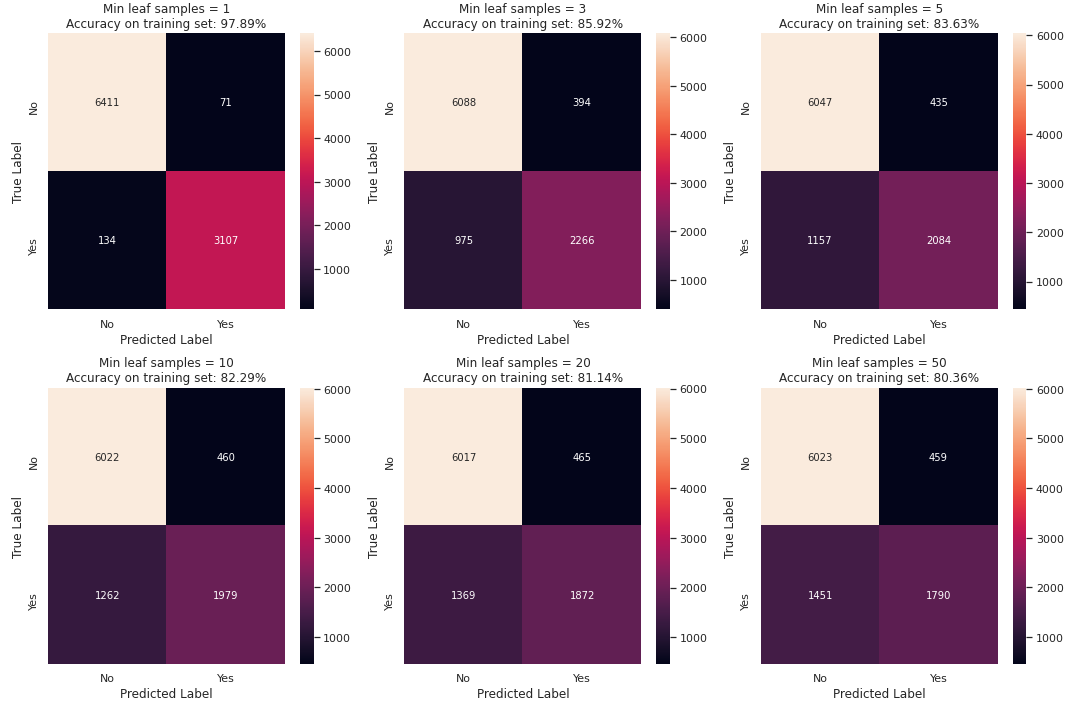

In [141]:
fig, ax = plt.subplots(2,3,figsize=(15,10))
ax = ax.flatten()
train_score = []

i=0
for axes in ax:
    # predict values
    trainPredicted = sampled_models[i].predict(trainX)
    y = ['No', 'Yes']

    # print confusion matrix
    sb.heatmap(confusion_matrix(trainY,trainPredicted),annot=True,fmt='d',yticklabels=y,xticklabels=y, ax=axes)
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')
    
    # compute score
    score = accuracy_score(trainY,trainPredicted)*100
    train_score.append(score)
    axes.set_title("Min leaf samples = {}\nAccuracy on training set: {:.2f}%".format(parameters[i],score))
    i+=1


plt.tight_layout()
plt.show()
#print()

Note:
- For all values of minimum leaf sampels, the model now has enough training instances to predict the correct label more often than not.
- These results cannot be directly compared to the previous models, as this is a different data set.
- However the validation set remains unchanged and will provide an unbiased evaluation.


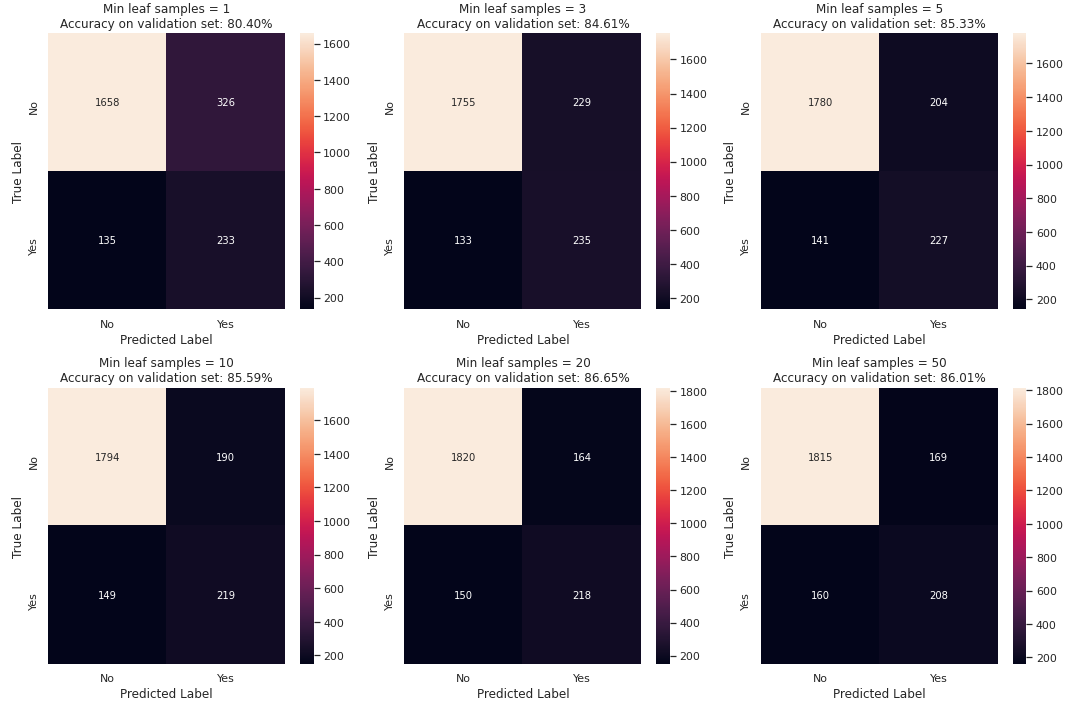

In [142]:
fig, ax = plt.subplots(2,3,figsize=(15,10))
ax = ax.flatten()
valid_score = []

i=0
for axes in ax:
    # predict values 
    validPredicted = sampled_models[i].predict(validX)
    
    # print confusion matrix
    y = ['No', 'Yes']
    sb.heatmap(confusion_matrix(validY,validPredicted),annot=True,fmt='d',yticklabels=y,xticklabels=y, ax=axes)
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')

    # compute score
    score = accuracy_score(validY,validPredicted)*100
    valid_score.append(score)
    axes.set_title("Min leaf samples = {}\nAccuracy on validation set: {:.2f}%".format(parameters[i],score))
    i+=1

plt.tight_layout()
plt.show()
#print()

Compared to the performance before over/under sampling the training set, the accuracy score is slightly less.

However, the ratio of falsely predicting the minority class is significantly improved for all values of the hyperparameter.

# Final performance on the test set.
Here we compare the performance before and after under/over sampling.

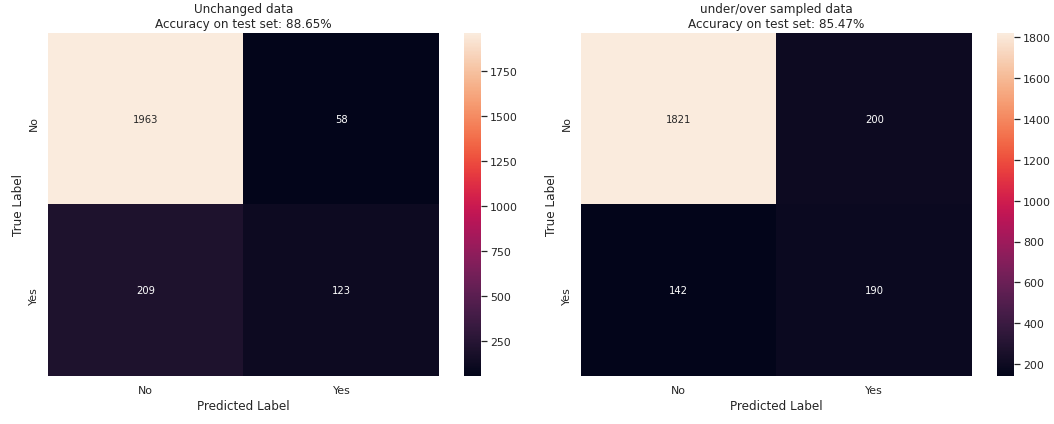

In [144]:
fig , ax = plt.subplots(1,2,figsize=(15,6))
ax = ax.flatten()

# model 1
testPredicted = models[1].predict(testX)
y = ['No', 'Yes']
sb.heatmap(confusion_matrix(testY,testPredicted),annot=True,fmt='d',yticklabels=y,xticklabels=y, ax=ax[0])
ax[0].set_ylabel('True Label')
ax[0].set_xlabel('Predicted Label')
score = accuracy_score(testY,testPredicted)*100
ax[0].set_title("Unchanged data\nAccuracy on test set: {:.2f}%".format(score))

# model 2
testPredicted = sampled_models[4].predict(testX)
y = ['No', 'Yes']
sb.heatmap(confusion_matrix(testY,testPredicted),annot=True,fmt='d',yticklabels=y,xticklabels=y, ax=ax[1])
ax[1].set_ylabel('True Label')
ax[1].set_xlabel('Predicted Label')
score = accuracy_score(testY,testPredicted)*100
ax[1].set_title("under/over sampled data\nAccuracy on test set: {:.2f}%".format(score))

plt.tight_layout()
plt.show()

# To conclude:
It is clear that one cannot simply look to accurcay metrics to determine if your model is performing adequetely.

In this case the first model has a higher accurcay, but performs unsatisfactory if you consider the false positive and false negative ratios.


## See if you can improve the performance on the test set further.

Consider using different models or sampling techniques.

In [81]:
from sklearn.svm import SVC

C = [1,3,5,7,9,11,15,20,30]
svc = []
i=0
for c in C:
    svc.append(SVC(gamma = 'scale', C=c, kernel='rbf'))
    svc[i].fit(X_train,y_train)
    i+=1

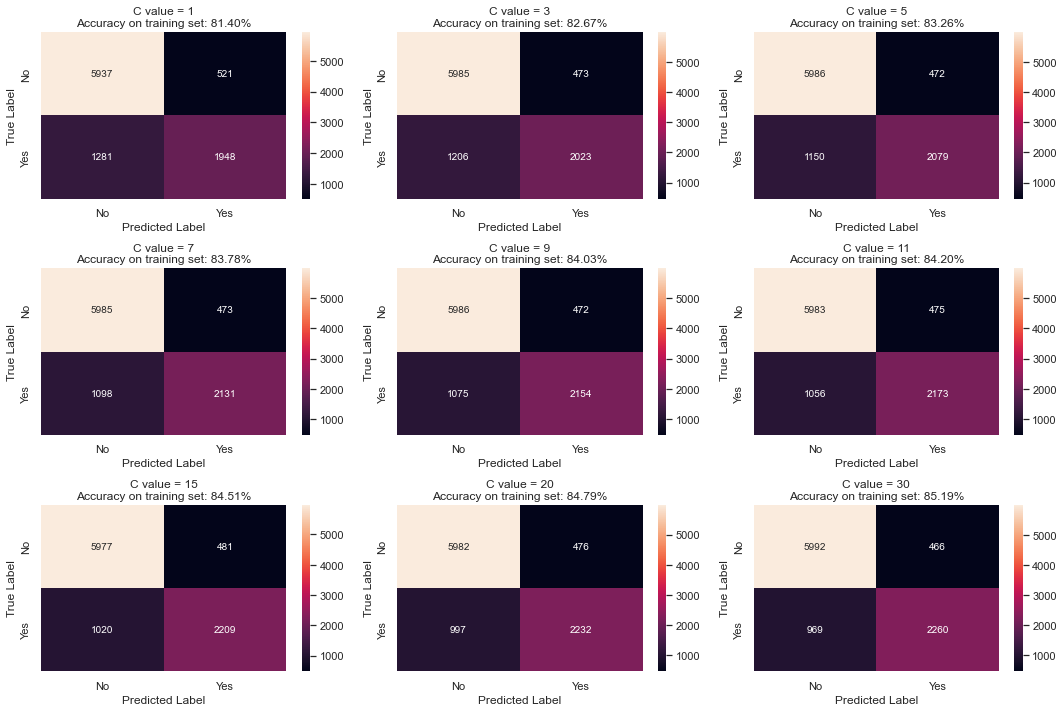

In [82]:
fig, ax = plt.subplots(3,3,figsize=(15,10))
ax = ax.flatten()
train_score = []

i=0
for axes in ax:
    # predict values
    trainPredicted = svc[i].predict(X_train)
    y = ['No', 'Yes']

    # print confusion matrix
    sns.heatmap(confusion_matrix(y_train,trainPredicted),annot=True,fmt='d',yticklabels=y,xticklabels=y, ax=axes)
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')
    
    # compute score
    score = accuracy_score(y_train,trainPredicted)*100
    train_score.append(score)
    axes.set_title("C value = {}\nAccuracy on training set: {:.2f}%".format(C[i],score))
    i+=1


plt.tight_layout()
plt.show()

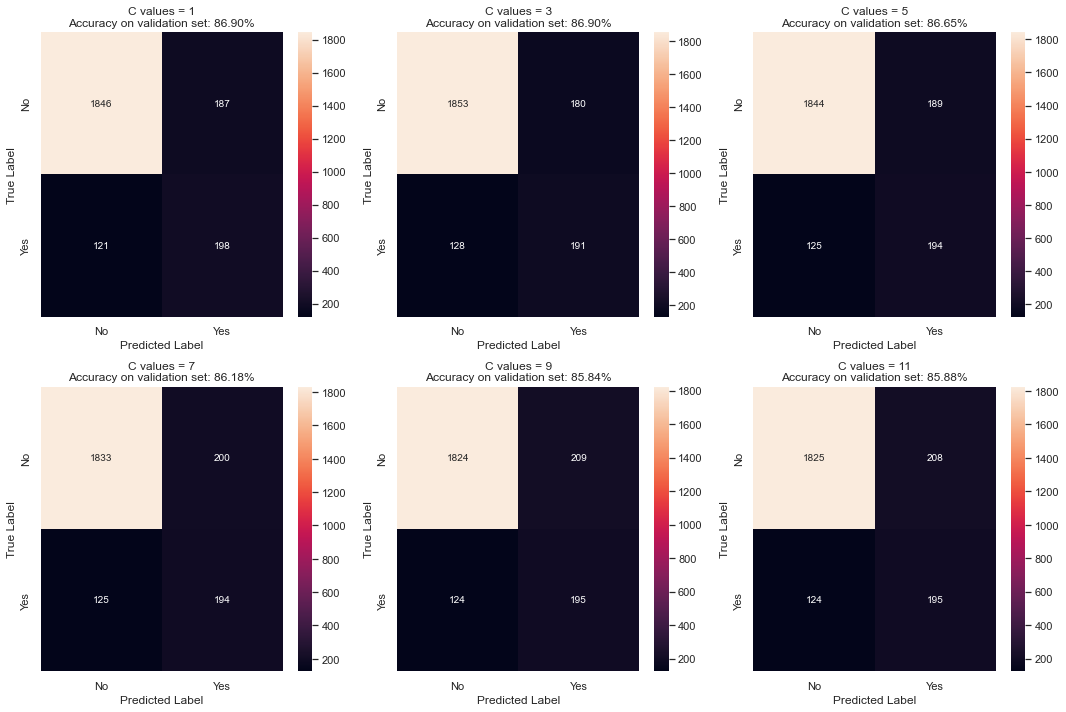

In [83]:
fig, ax = plt.subplots(2,3,figsize=(15,10))
ax = ax.flatten()
valid_score = []

i=0
for axes in ax:
    # predict values 
    validPredicted = svc[i].predict(X_val)
    
    # print confusion matrix
    y = ['No', 'Yes']
    sns.heatmap(confusion_matrix(y_val,validPredicted),annot=True,fmt='d',yticklabels=y,xticklabels=y, ax=axes)
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')

    # compute score
    score = accuracy_score(y_val,validPredicted)*100
    valid_score.append(score)
    axes.set_title("C values = {}\nAccuracy on validation set: {:.2f}%".format(C[i],score))
    i+=1

plt.tight_layout()
plt.show()
#print()

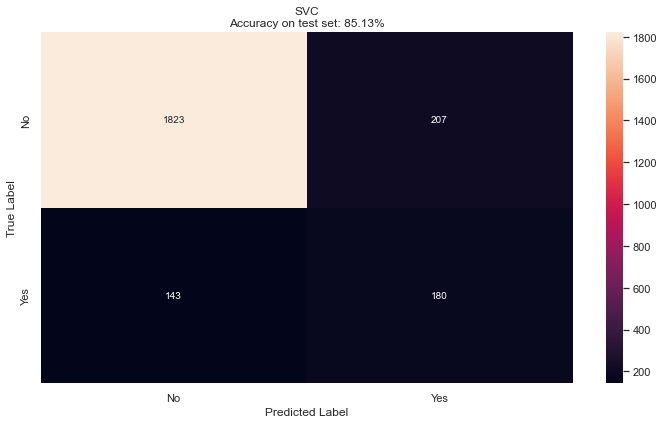

In [84]:
plt.figure(figsize=(10,6))

testPredicted = svc[4].predict(X_test)
y = ['No', 'Yes']
sns.heatmap(confusion_matrix(y_test,testPredicted),annot=True,fmt='d',yticklabels=y,xticklabels=y)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
score = accuracy_score(y_test,testPredicted)*100
plt.title("SVC\nAccuracy on test set: {:.2f}%".format(score))

plt.tight_layout()
plt.show()

In [85]:
from sklearn.tree import DecisionTreeClassifier

depth = [1,3,5,7,9,11,15,20,30]
clf = []
i=0
for num in depth:
    clf.append(DecisionTreeClassifier(max_depth=num))
    clf[i].fit(X_train,y_train)
    i+=1

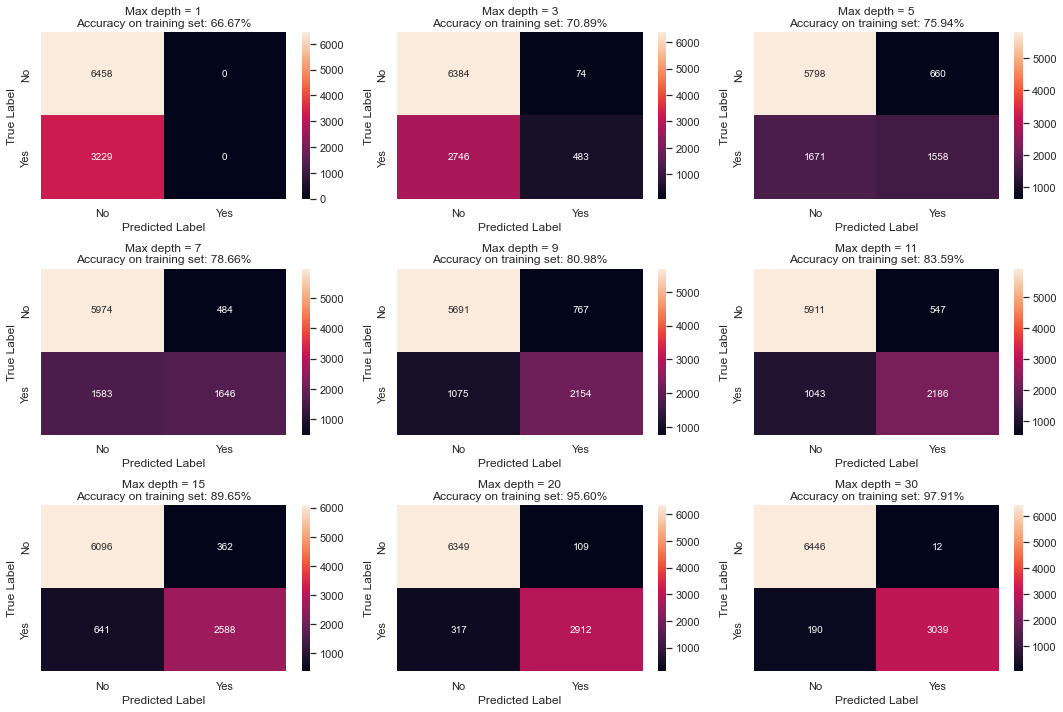

In [86]:
fig, ax = plt.subplots(3,3,figsize=(15,10))
ax = ax.flatten()
train_score = []

i=0
for axes in ax:
    # predict values
    trainPred = clf[i].predict(X_train)
    y = ['No', 'Yes']

    # print confusion matrix
    sns.heatmap(confusion_matrix(y_train,trainPred),annot=True,fmt='d',yticklabels=y,xticklabels=y, ax=axes)
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')
    
    # compute score
    score = accuracy_score(y_train,trainPred)*100
    train_score.append(score)
    axes.set_title("Max depth = {}\nAccuracy on training set: {:.2f}%".format(depth[i],score))
    i+=1


plt.tight_layout()
plt.show()

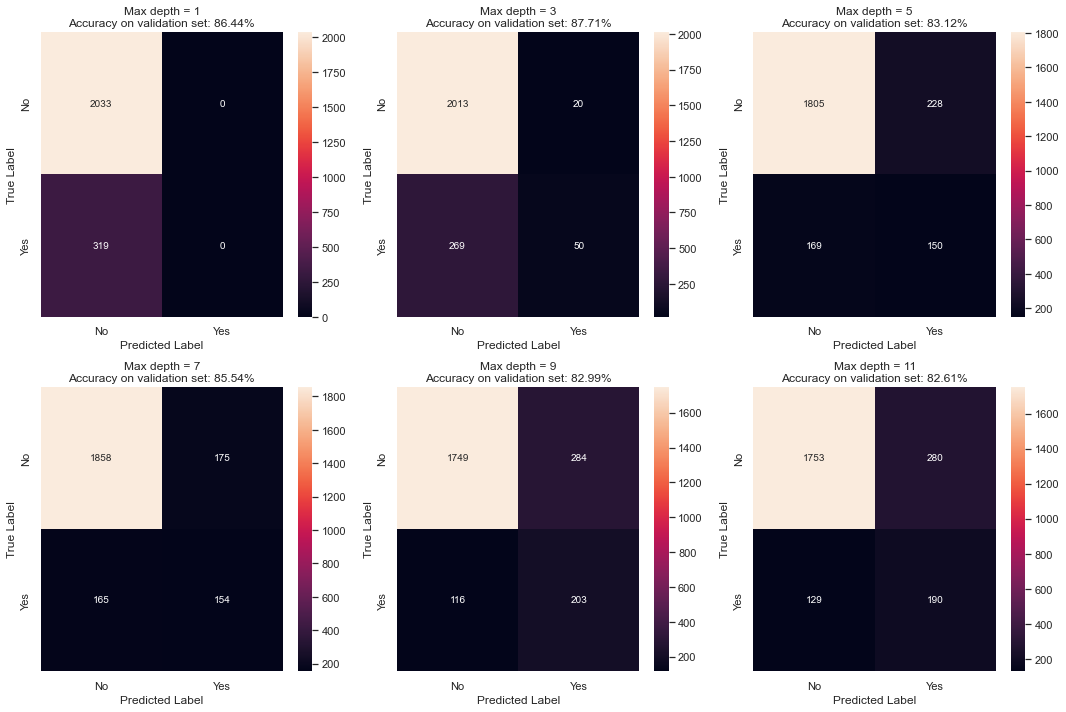

In [88]:
fig, ax = plt.subplots(2,3,figsize=(15,10))
ax = ax.flatten()
valid_score = []

i=0
for axes in ax:
    # predict values 
    valPred = clf[i].predict(X_val)
    
    # print confusion matrix
    y = ['No', 'Yes']
    sns.heatmap(confusion_matrix(y_val,valPred),annot=True,fmt='d',yticklabels=y,xticklabels=y, ax=axes)
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')

    # compute score
    score = accuracy_score(y_val,valPred)*100
    valid_score.append(score)
    axes.set_title("Max depth = {}\nAccuracy on validation set: {:.2f}%".format(depth[i],score))
    i+=1

plt.tight_layout()
plt.show()
#print()

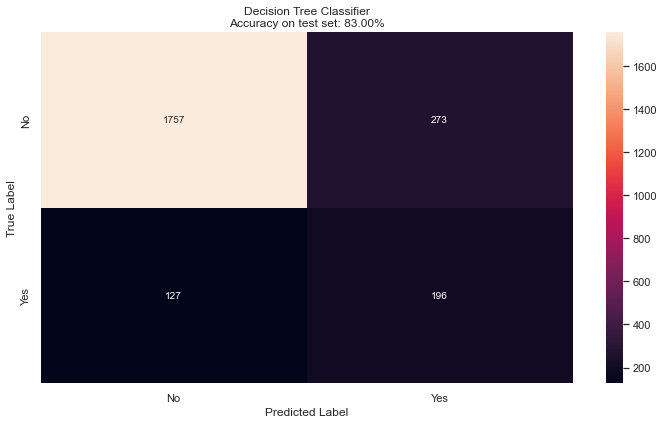

In [90]:
plt.figure(figsize=(10,6))

testPredicted = clf[4].predict(X_test)
y = ['No', 'Yes']
sns.heatmap(confusion_matrix(y_test,testPredicted),annot=True,fmt='d',yticklabels=y,xticklabels=y)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
score = accuracy_score(y_test,testPredicted)*100
plt.title("Decision Tree Classifier\nAccuracy on test set: {:.2f}%".format(score))

plt.tight_layout()
plt.show()